## [1. Import Needed Modules](#import) ##
## [2 Concept for Callback Approach](#concept) ##
## [3. Define function to print text in rgb foreground and background colors](#pc) ##
## [4 Define a function to plot the number of images for each label in a dataframel](#pcounts) ##
## [5. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [6. Create train, test and validation generators](#generators) ## 
## [7. Create a function to show Training Image Samples](#show) ## 
## [8 Create a function to calculate the F1 score metric](#f1metric) ##
## [9. Create the Model](#model) ## 
## [10. Create a custom Keras callback to continue or halt training](#callback) ## 
## [11. Instantiate custom callback ](#callbacks) ##
## [12. Train the model](#train) ##
## [13. Define a function to plot the training data](#plot) ##
## [14. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [15 Print the list of misclassified test files](#perrors) ##
## [16 Save the model](#save) ##

<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


<a id="concept"></a>
# <center>Custom Callback Concept</center>
This notebook implements a custom callback to adjust the learning rate during training.  
The callback has a parameter dwell. If dwell is set to True, the callback monitors the  
validation loss. It keeps track of the lowest validation loss thus far achieved as you run  
through each epoch and stores this as the lowest loss and also stores the weights for that  
epoch as the best weights. At the end of an epoch the validation loss for that epoch is  
compared with the lowest loss. If the validation loss at the end of the current epoch is  
less than the lowest loss than it becomes the lowest loss and the weights of the current  
epoch become the best weights  
  
If the validation loss at the end of the current epoch is greator than the lowest loss    
this implies you have moved to a location in Nspace(N is the number of trainable parameters    
on the validation cost function surface that is less favorable(higher cost) than the position  
in Nspace defined by the best weights. Therefore why move the models weights to this less  
favorable location? Better to reset the models weights to the best weights, then lower the  
learning rate and run more epochs. The new learning rate is set to new_lr=current_lr * factor  
where factor is a user specified parameter in the instantiation of the callback. By default  
it is set to .04 and by default dwell is set to True.  
  
At the end of training the callback always returns your model with the weights set to the  
best weights. The callback provides a feature where it periodically queries the user to  
either contine and optionally manually specify a new learning rate or halt training.  
During training the calback provides useful information on the percent improvement in the  
validation loss for each epoch. The is useful to decide when to halt training or manually  
specifying a new learning rate.  

<a id="pc"></a>

<a id="pc"></a>
## <center>Define a function to print text in specified rgb foreground and background colors</center>
### Add some PZAZZ to your printed output with this function  
form of the call is:  print_in_color(txt_msg, fore_tupple, back_tupple where:
* txt_msg is the string to be printed out  
* fore_tuple is tuple of the form (r,g,b) specifying the foreground color of the text
* back_tuple is tuple of the form (r,g,b) specifying the background color of the text

In [2]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



<a id="pcounts"></a>
## <center>Define a function that plots value counts for a column in a dataframe</center>

In [3]:
def plot_label_count (df, column):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    plt.figure(figsize=(15,4))
    form = {'family': 'serif', 'color': 'blue', 'size': 25} 
    plt.bar(labels, values)
    plt.title('Images per label in training set', fontsize= 24, color='blue')
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Labels", fontdict=form)
    plt.ylabel('Number of Images', fontdict=form)
    plt.show()

**<a id="makedf"></a>
# <center>Read in data and create train, test and validation data frames</center>
### I will just take this as a classification problem where I try to classify the 10 plant species

train_df length:  7961   test_df length:  996   valid_df length:  995


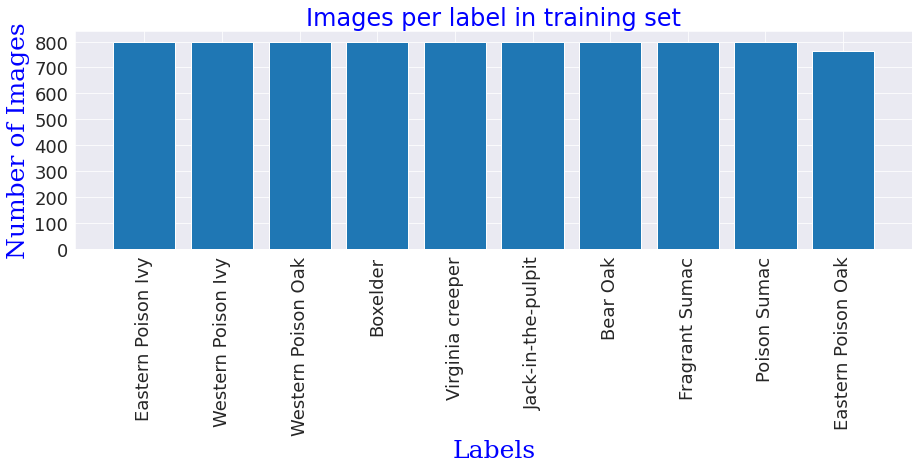

average image height=  465   average image width=  402  aspect ratio h/w=  1.1567164179104477


In [4]:
def make_dataframes(csvpath):    
    df=pd.read_csv(csvpath)
    df=df.drop(['class_id','scientific_name', 'herbarium22_category_id', 'species_label'], axis=1)
    df.columns=['labels', 'filepaths','toxicity']    
    train_df,dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df,test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    plot_label_count (train_df, 'labels')
    sample_df=train_df.sample(n=100, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count

csvpath=r'../input/toxic-plant-classification/tpc-imgs/full_metadata.csv'
train_df, test_df, valid_df, classes, class_count = make_dataframes(csvpath)
    

<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [5]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps




In [6]:
img_size = (224,200)
batch_size=30
ycol='labels'
train_gen, test_gen, valid_gen, test_steps= make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size)

Found 7961 validated image filenames belonging to 10 classes.          for train generator 
Found 995 validated image filenames belonging to 10 classes.           for valid generator 
Found 996 validated image filenames belonging to 10 classes.           for test generator 
test batch size:  12   test steps:  83  number of classes :  10


<a id="show"></a>
# <center>Create a function to show example training images</center>

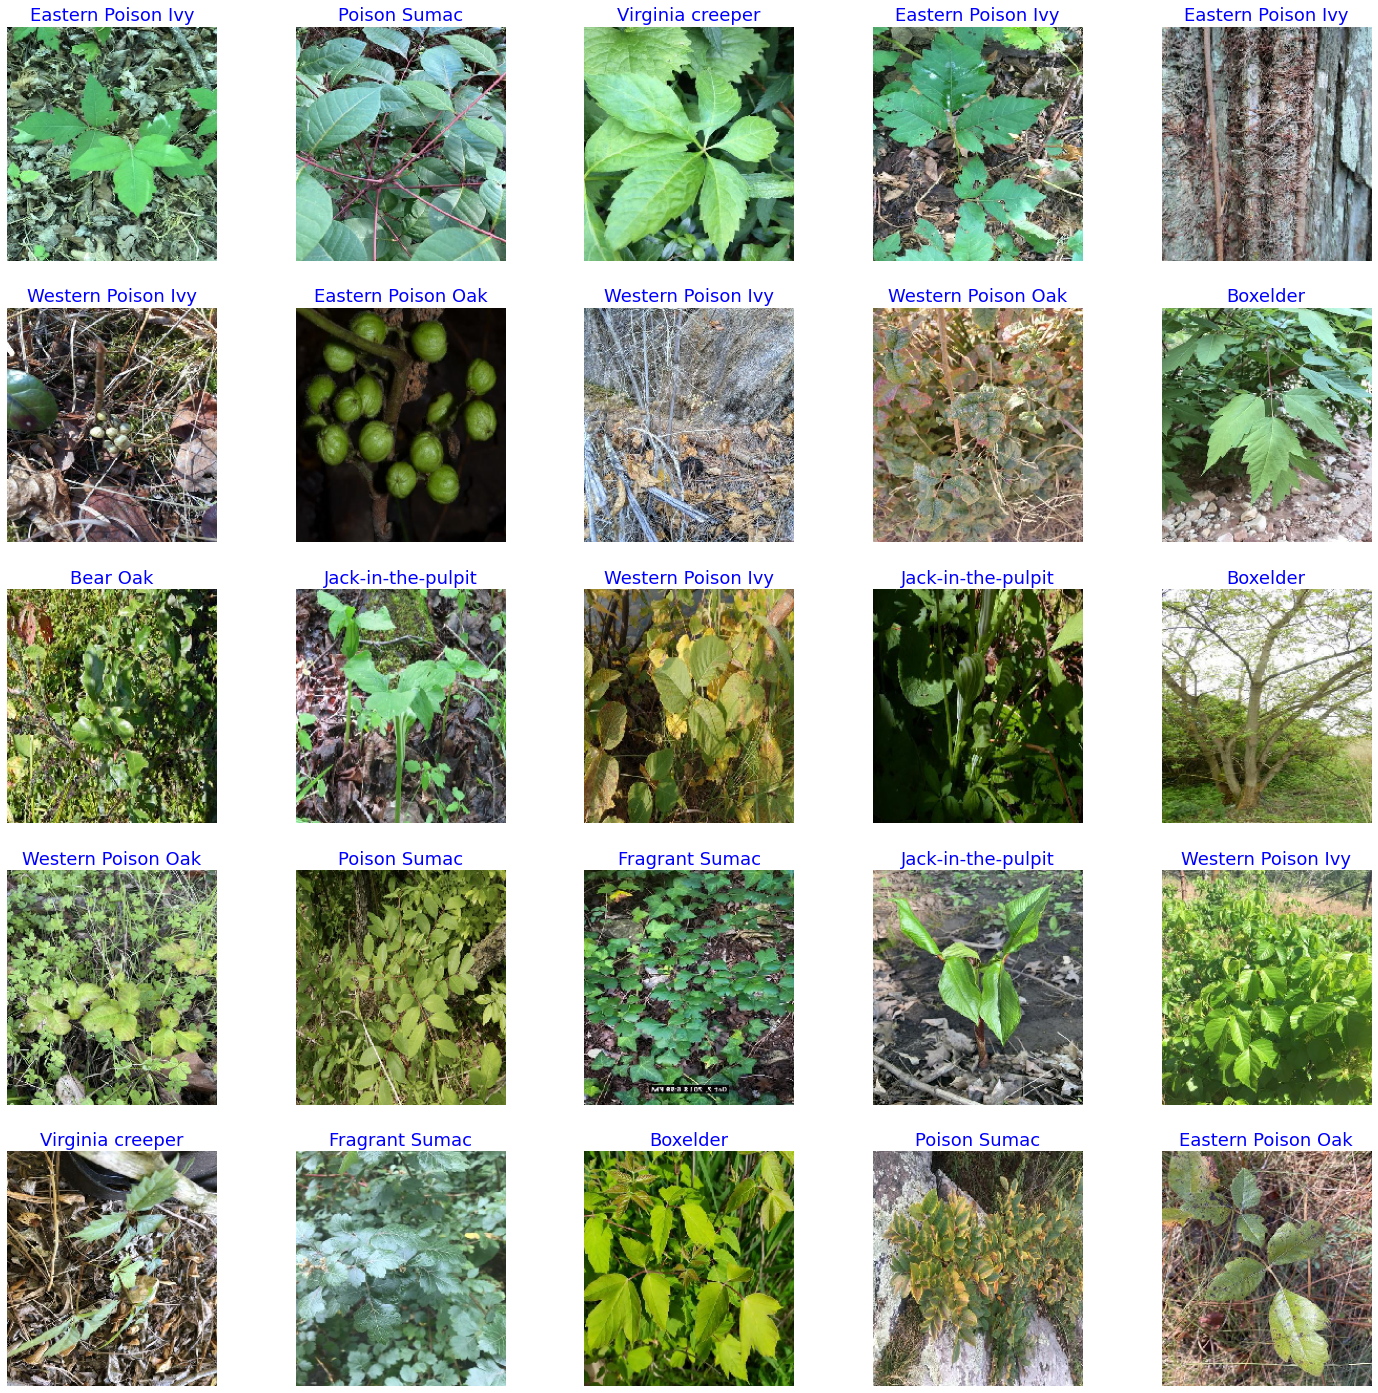

In [7]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="f1metric"></a>
# <center>Create a function to calculate the F1 score metric</center>

In [8]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable when you do transfer learning. Then train for some number of epochs then fine tune model by making base model trainable and run more epochs. I have found this to be WRONG!!!! Making the base model trainable from the outset leads to faster convegence and a lower validation loss for the same number of total epochs! Insure  you initialize the transfer model with imagenet weights

In [9]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

43950080/43941136 [==============================] - 0s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [10]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [11]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning. The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights.I have done a lot of testing running both ways hand have always found this to be true

In [12]:

history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
266/266 [==============================] - 177s 573ms/step - loss: 7.9471 - accuracy: 0.4071 - F1_score: 0.3435 - auc: 0.7992 - val_loss: 5.9979 - val_accuracy: 0.5920 - val_F1_score: 0.5520 - val_auc: 0.9139

 validation loss of  5.9979 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

Epoch 2/40
266/266 [==============================] - 149s 561ms/step - loss: 4.7746 - accuracy: 0.6433 - F1_score: 0.5819 - auc: 0.9327 - val_loss: 3.8980 - val_accuracy: 0.6563 - val_F1_score: 0.6138 - val_auc: 0.9391

 validation loss of  3.8980 is 35.0115 % below lowest loss, saving weights from epoch 2   as best weights

Epoch 3/40
266/266 [==============================] - 149s 558ms/step - loss: 3.0325 - accuracy: 0.7464 - F1_score: 0.71

  lowering the learning rate got to a lower validation loss so lets run for 2 more epochs


User comment: lowering the learning rate got to a lower validation loss so lets run for 2 more epochs


 Enter H to end training or  an integer for the number of additional epochs to run then ask again



 2


you entered 2 Training will continue to epoch 12

Epoch 11/40
266/266 [==============================] - 149s 561ms/step - loss: 0.3809 - accuracy: 0.9807 - F1_score: 0.9752 - auc: 0.9995 - val_loss: 1.0831 - val_accuracy: 0.7508 - val_F1_score: 0.7466 - val_auc: 0.9551

 validation loss of  1.0831 is  2.7888 % below lowest loss, saving weights from epoch 11  as best weights

Epoch 12/40
266/266 [==============================] - 150s 565ms/step - loss: 0.3407 - accuracy: 0.9852 - F1_score: 0.9823 - auc: 0.9997 - val_loss: 1.0708 - val_accuracy: 0.7457 - val_F1_score: 0.7512 - val_auc: 0.9535

 validation loss of  1.0708 is  1.1355 % below lowest loss, saving weights from epoch 12  as best weights

press enter to continue or enter a comment  below 



  we are near the minimum validation loss the model can achieve so halt training


User comment: we are near the minimum validation loss the model can achieve so halt training


 Enter H to end training or  an integer for the number of additional epochs to run then ask again



 h


you entered h,  Training halted on epoch 12 due to user input


loading model with weights from epoch 12

training elapsed time was 0.0 hours, 32.0 minutes, 54.84 seconds)



<a id="plot"></a>
# <center>Define a function to plot the training data

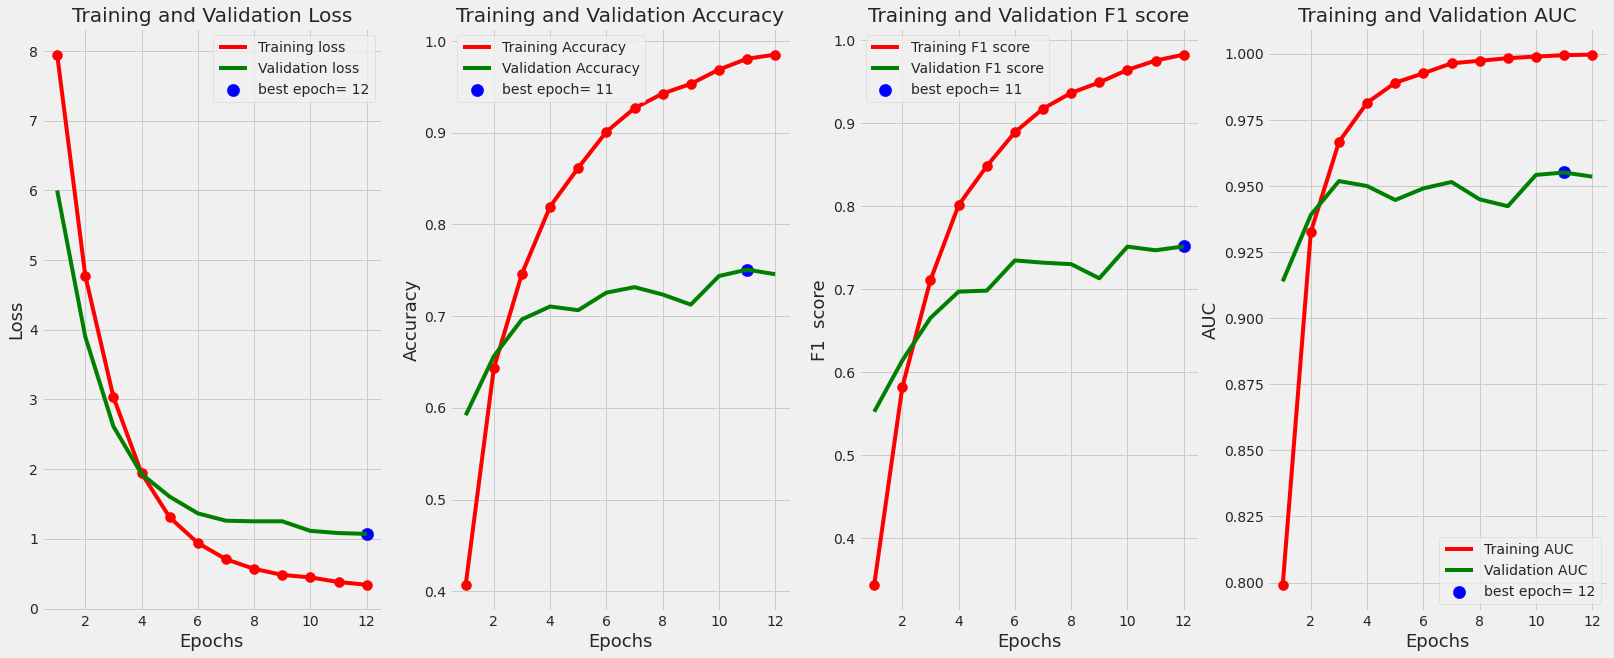

In [13]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')    
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout    
    plt.show()
    return 
    
tr_plot(history)

<a id="result"></a>
# <center>Make Predictions on the test set</center>
### Define a function which takes in a test generator  and generates predictions on the test set including a confusion matrix and a classification report

83/83 [==============================] - 11s 100ms/step
there were 234 errors in 996 tests for an accuracy of  76.51



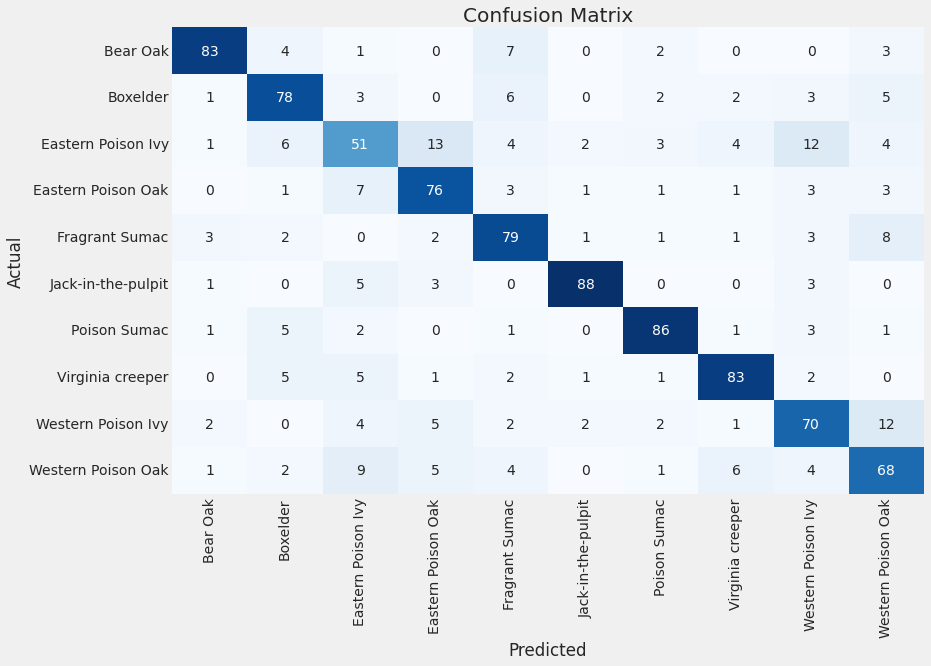

Classification Report:
----------------------
                     precision    recall  f1-score   support

          Bear Oak     0.8925    0.8300    0.8601       100
          Boxelder     0.7573    0.7800    0.7685       100
Eastern Poison Ivy     0.5862    0.5100    0.5455       100
Eastern Poison Oak     0.7238    0.7917    0.7562        96
    Fragrant Sumac     0.7315    0.7900    0.7596       100
Jack-in-the-pulpit     0.9263    0.8800    0.9026       100
      Poison Sumac     0.8687    0.8600    0.8643       100
  Virginia creeper     0.8384    0.8300    0.8342       100
Western Poison Ivy     0.6796    0.7000    0.6897       100
Western Poison Oak     0.6538    0.6800    0.6667       100

          accuracy                         0.7651       996
         macro avg     0.7658    0.7652    0.7647       996
      weighted avg     0.7660    0.7651    0.7648       996



In [14]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

<a id="perrors"></a>
# <center>If the are less than 50 misclassifications print the misclassified files </a>

In [15]:
def print_errors(error_list):
    if len(error_list) == 0:
        print_in_color('There were no errors in predicting the test set')
    else:
        if len(error_list)>50:
            print_in_color('There were over 50 misclassifications, the error list will not be printed')
        else:
            print ('Below is a list of test files that were miss classified \n')
            print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))            
            for i in range(len(error_list)):
                fpath=error_list[i]                
                split=fpath.split('/') 
                slength=len(split)
                f=split[slength-2]+ '-' + split[slength-1]
                print(f'{f:^30s}{error_pred_list[i]:^30s}')

In [16]:
print_errors(error_list)

There were over 50 misclassifications, the error list will not be printed



<a id="save"></a>
# <center>Save the model </center>

In [34]:
def save_model(subject, classes, img_size, f1score, working_dir):
    name=subject + '-' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
    save_id=f'{name}-{f1score:5.2f}.h5'
    model_save_loc=os.path.join(working_dir, save_id)
    model.save(model_save_loc)
    msg= f'model was saved as {model_save_loc}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

In [35]:
working_dir=r'./'
subject='plants'
save_model(subject, classes, img_size, f1score, working_dir)

model was saved as ./plants-10-(224 X 200)-76.48.h5

